In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [15]:
img_height, img_width = 150, 150
batch_size = 32
num_epochs = 10

In [16]:
train_data_dir = 'D:\\Datasets\\Nowy folder\\archive\\train'
test_data_dir = 'D:\\Datasets\\Nowy folder\\archive\\test'

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [18]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

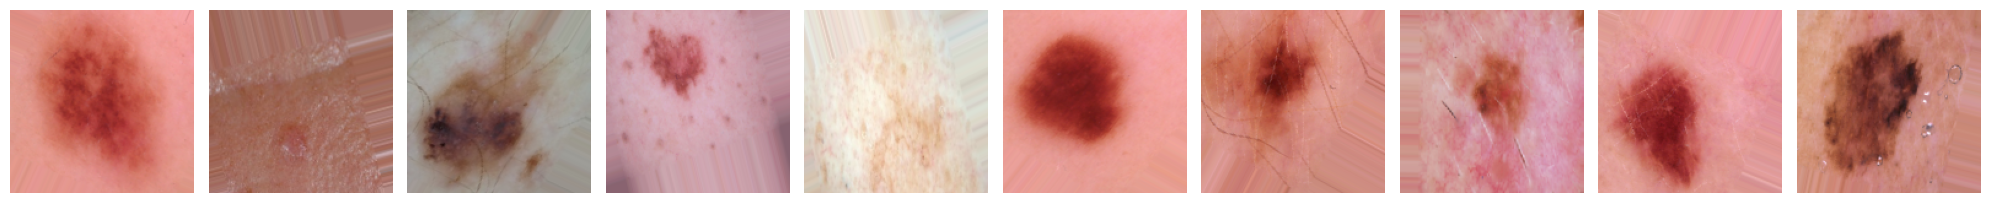

In [20]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
images, labels = next(train_generator)

plot_images(images[:10])

In [21]:
import optuna

In [22]:
def create_model(trial):
    model = Sequential()

    model.add(Conv2D(trial.suggest_int('filters1', 32, 128, step=32), 
                     (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
    model.add(MaxPooling2D((2, 2)))

    if trial.suggest_categorical('conv2', [True, False]):
        model.add(Conv2D(trial.suggest_int('filters2', 32, 128, step=32), (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    
    if trial.suggest_categorical('conv3', [True, False]):
        model.add(Conv2D(trial.suggest_int('filters3', 32, 128, step=32), (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(trial.suggest_int('units', 128, 512, step=128), activation='relu'))
    
    model.add(Dropout(trial.suggest_float('dropout', 0.2, 0.5)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [23]:
def objective(trial):
    model = create_model(trial)
    
    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=test_generator,
        verbose=0
    )
    
    score = model.evaluate(test_generator, verbose=0)
    return score[1]  

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  

[I 2024-05-19 21:25:21,276] A new study created in memory with name: no-name-7ec7dd02-6942-404f-82dd-2bbf32ab02e6
[I 2024-05-19 21:27:54,964] Trial 0 finished with value: 0.8136363625526428 and parameters: {'filters1': 64, 'conv2': True, 'filters2': 96, 'conv3': False, 'units': 512, 'dropout': 0.40642472896064047, 'learning_rate': 0.0004517110654434368}. Best is trial 0 with value: 0.8136363625526428.
[I 2024-05-19 21:30:27,477] Trial 1 finished with value: 0.7924242615699768 and parameters: {'filters1': 128, 'conv2': True, 'filters2': 128, 'conv3': False, 'units': 128, 'dropout': 0.24596499180672354, 'learning_rate': 0.00021197572084121893}. Best is trial 0 with value: 0.8136363625526428.
[I 2024-05-19 21:32:58,050] Trial 2 finished with value: 0.7818182110786438 and parameters: {'filters1': 32, 'conv2': True, 'filters2': 128, 'conv3': False, 'units': 384, 'dropout': 0.35947218865070474, 'learning_rate': 1.6548949533078523e-05}. Best is trial 0 with value: 0.8136363625526428.
[I 2024-

In [25]:
print('Best trial:')
trial = study.best_trial
print(f'  Accuracy: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Accuracy: 0.8136363625526428
  Params: 
    filters1: 64
    conv2: True
    filters2: 96
    conv3: False
    units: 512
    dropout: 0.40642472896064047
    learning_rate: 0.0004517110654434368


In [26]:
best_model = create_model(trial)
history = best_model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

Epoch 1/20
83/83 [==============================] - 19s 204ms/step - loss: 0.7143 - accuracy: 0.6784 - val_loss: 0.5406 - val_accuracy: 0.7667
Epoch 2/20
83/83 [==============================] - 16s 188ms/step - loss: 0.4984 - accuracy: 0.7414 - val_loss: 0.4684 - val_accuracy: 0.7697
Epoch 3/20
83/83 [==============================] - 16s 187ms/step - loss: 0.4740 - accuracy: 0.7653 - val_loss: 0.3984 - val_accuracy: 0.7818
Epoch 4/20
83/83 [==============================] - 15s 184ms/step - loss: 0.4432 - accuracy: 0.7929 - val_loss: 0.4136 - val_accuracy: 0.8015
Epoch 5/20
83/83 [==============================] - 16s 186ms/step - loss: 0.4293 - accuracy: 0.7941 - val_loss: 0.3928 - val_accuracy: 0.7879
Epoch 6/20
83/83 [==============================] - 15s 186ms/step - loss: 0.4180 - accuracy: 0.8013 - val_loss: 0.3708 - val_accuracy: 0.8152
Epoch 7/20
83/83 [==============================] - 15s 180ms/step - loss: 0.4132 - accuracy: 0.8005 - val_loss: 0.3707 - val_accuracy: 0.8167

In [27]:
best_model.save('optuna_skin_cancer_classifier.h5')

test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

21/21 [==============================] - 1s 42ms/step - loss: 0.3399 - accuracy: 0.8394
Test accuracy: 0.8393939137458801


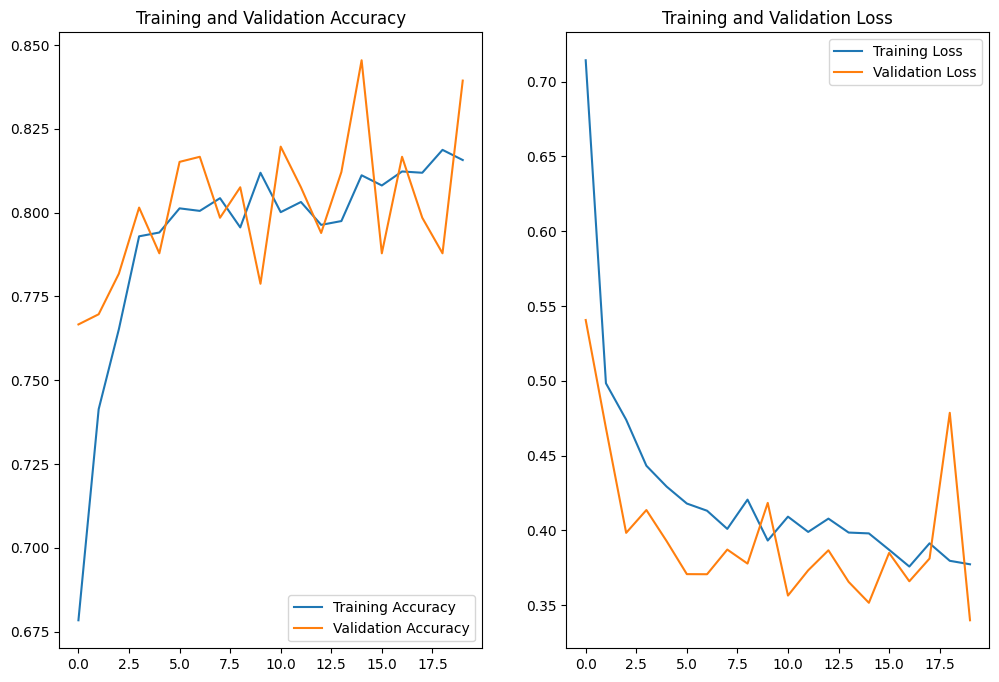

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()